# Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from DataGen import DataGen

mats = np.array(['None', 'Ag', 'Al', 'Au', 'Cu', 'GaAs', 'InAs', 'InP', 'Mo', 'Si', 'SiO2'])
w_g = np.linspace(300, 800, 200) # Setting operating wavelength range

C:\Users\Tanzim\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


# Loading Models

In [2]:
model_tandem = keras.models.load_model('./Models/inversenet_tandem_generator_multiple_losses.hd5')
model_cvae = keras.models.load_model('./Models/decoder_categorical.h5')

# Tandem

## Sample predictions

### Random sample

             m1    m2         t1         t2
Test       InAs    Au  82.261363  17.687108
Predicted  InAs    Au  77.214420  14.168501
Error      True  True   5.046943   3.518607


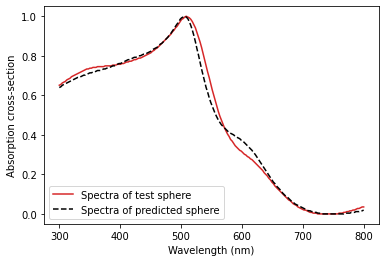

In [10]:
# Randomly sampling m1 and m2
m1 = np.random.randint(1, 11)
m2 = np.random.randint(1, 11)
while m2 == m1:
    m2 = np.random.randint(1, 11) # Ensuring m1 and m2 are distinct

# Randomly sampling t1 and t2 while also ensuring t1, t2 >= 1 and t1 + t2 <= 100
min_thick = 1
max_thick = 100
t1 = np.random.uniform(min_thick, max_thick-min_thick)
max_thick -= t1
t2 = np.random.uniform(min_thick, max_thick)

# Generating spectrum of test input sample
gen = DataGen((m1, m2), (t1, t2), host='wat')
gen.generate()
gen.normalise()
q_abs = gen.q_abs/255 # Normalising spectrum between 0 and 1

# Model prediction
m1_pred, m2_pred, t1_pred, t2_pred = model_tandem.predict(q_abs.reshape(1, -1), verbose=0)
m1_pred = np.argmax(m1_pred[0])
m2_pred = np.argmax(m2_pred[0])
t1_pred = t1_pred[0][0]*100
t2_pred = t2_pred[0][0]*100

# Thickness values are set to a minimum of 1
if t1_pred < 1:
      t1_pred = 1
if t2_pred < 1:
      t2_pred = 1

# Generating spectrum of predicted nanosphere
gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
gen.generate()
gen.normalise()
q_abs_pred = gen.q_abs/255 # Normalising spectrum between 0 and 1

# Comparison between test and predicted nanospheres
data = [[mats[m1], mats[m2], t1, t2],
        [mats[m1_pred], mats[m2_pred], t1_pred, t2_pred], 
        [m1==m1_pred, m2==m2_pred, abs(t1-t1_pred), abs(t2-t2_pred)]]
pred_df = pd.DataFrame(data, columns=('m1', 'm2', 't1', 't2'), index=('Test', 'Predicted', 'Error'))

print(pred_df)

# Comparison between test and predicted spectra
fig = plt.figure()
plt.plot(w_g, q_abs, color='tab:red')
plt.plot(w_g, q_abs_pred, color='black', linestyle='--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption cross-section')
plt.legend(('Spectra of test sphere', 'Spectra of predicted sphere'))
plt.show()

### Experimental sample

             m1     m2         t1        t2
Test         Au     Ag          ?         ?
Predicted    Au     Au  47.112408  6.480937
Error      True  False          ?         ?


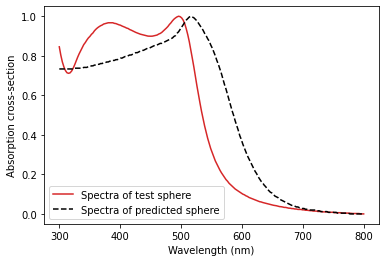

In [11]:
# Setting m1 and m2 to Au@Ag
m1 = 3 # Au
m2 = 1 # Ag

# Importing experimental data
ds = pd.read_csv('Spectra/auag_experimental.csv', sep=',')
w = ds['WL']
q_abs = ds['AuAg_90_140822']

# Normalising spectrum between 0 and 1
q_abs = np.interp(w_g, np.array(w, dtype=np.float64), np.array(q_abs, dtype=np.float64))
q_abs = (q_abs - np.min(q_abs)) / (np.max(q_abs) - np.min(q_abs))

# Model prediction
m1_pred, m2_pred, t1_pred, t2_pred = model_tandem.predict(q_abs.reshape(1, -1), verbose=0)
m1_pred = np.argmax(m1_pred[0])
m2_pred = np.argmax(m2_pred[0])
t1_pred = t1_pred[0][0]*100
t2_pred = t2_pred[0][0]*100

# Thickness values are set to a minimum of 1
if t1_pred < 1:
      t1_pred = 1
if t2_pred < 1:
      t2_pred = 1

# Generating spectrum of predicted nanosphere
gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
gen.generate()
gen.normalise()
q_abs_pred = gen.q_abs/255 # Normalising spectrum between 0 and 1

# Comparison between test and predicted nanospheres
data = [[mats[m1], mats[m2], '?', '?'],
      [mats[m1_pred], mats[m2_pred], t1_pred, t2_pred], 
      [m1==m1_pred, m2==m2_pred, '?', '?']]
pred_df = pd.DataFrame(data, columns=('m1', 'm2', 't1', 't2'), index=('Test', 'Predicted', 'Error'))

print(pred_df)

# Comparison between test and predicted spectra
fig = plt.figure()
plt.plot(w_g, q_abs, color='tab:red')
plt.plot(w_g, q_abs_pred, color='black', linestyle='--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption cross-section')
plt.legend(('Spectra of test sphere', 'Spectra of predicted sphere'))
plt.show()

## Model Testing

In [12]:
N = 100 # Number of samples to test on

m1_acc = 0
m2_acc = 0
t1_err = 0
t2_err = 0

for i in range(N):
    print(f'Now {i+1}')
    m1 = np.random.randint(1, 11)
    m2 = np.random.randint(1, 11)

    while m2 == m1:
        m2 = np.random.randint(1, 11)

    min_thick = 1
    max_thick = 100
    t1 = np.random.uniform(min_thick, max_thick-min_thick)
    max_thick -= t1
    if m2 != 0 and max_thick>=min_thick:
        t2 = np.random.uniform(min_thick, max_thick)
        max_thick -= t2

    gen = DataGen((m1, m2), (t1, t2), host='wat')
    gen.generate()
    gen.normalise()
    q_abs = gen.q_abs/255

    m1_pred, m2_pred, t1_pred, t2_pred = model_tandem.predict(q_abs.reshape(1, -1), verbose=0)
    m1_pred = np.argmax(m1_pred[0])
    m2_pred = np.argmax(m2_pred[0])
    t1_pred = t1_pred[0][0]*100
    t2_pred = t2_pred[0][0]*100

    if m1_pred == m1:
        m1_acc += 1

    if m2_pred == m2:
        m2_acc += 1

    t1_err += np.abs(t1_pred - t1)
    t2_err += np.abs(t2_pred - t2)

print(f'm1 Accuracy: {m1_acc/N*100}\nm2 Accuracy: {m2_acc/N*100}\nt1 MAE: {t1_err/N}\nt2 MAE: {t2_err/N}')

Now 1
Now 2
Now 3
Now 4
Now 5
Now 6
Now 7
Now 8
Now 9
Now 10
Now 11
Now 12
Now 13
Now 14
Now 15
Now 16
Now 17
Now 18
Now 19
Now 20
Now 21
Now 22
Now 23
Now 24
Now 25
Now 26
Now 27
Now 28
Now 29
Now 30
Now 31
Now 32
Now 33
Now 34
Now 35
Now 36
Now 37
Now 38
Now 39
Now 40
Now 41
Now 42
Now 43
Now 44
Now 45
Now 46
Now 47
Now 48
Now 49
Now 50
Now 51
Now 52
Now 53
Now 54
Now 55
Now 56
Now 57
Now 58
Now 59
Now 60
Now 61
Now 62
Now 63
Now 64
Now 65
Now 66
Now 67
Now 68
Now 69
Now 70
Now 71
Now 72
Now 73
Now 74
Now 75
Now 76
Now 77
Now 78
Now 79
Now 80
Now 81
Now 82
Now 83
Now 84
Now 85
Now 86
Now 87
Now 88
Now 89
Now 90
Now 91
Now 92
Now 93
Now 94
Now 95
Now 96
Now 97
Now 98
Now 99
Now 100
Now 101
Now 102
Now 103
Now 104
Now 105
Now 106
Now 107
Now 108
Now 109
Now 110
Now 111
Now 112
Now 113
Now 114
Now 115
Now 116
Now 117
Now 118
Now 119
Now 120
Now 121
Now 122
Now 123
Now 124
Now 125
Now 126
Now 127
Now 128
Now 129
Now 130
Now 131
Now 132
Now 133
Now 134
Now 135
Now 136
Now 137
Now 138
Now 

# cVAE

## Sample predictions

### Random sample

              m1     m2         t1         t2
Test          Cu   SiO2  15.056668  29.764534
Predicted     Mo     Cu   1.000000  20.688662
Error      False  False  14.056668   9.075872


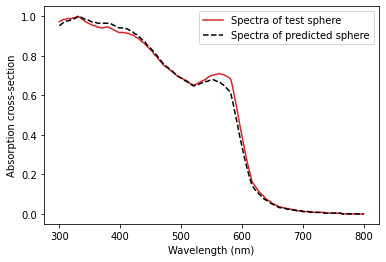

In [15]:
# Randomly sampling m1 and m2
m1 = np.random.randint(1, 11)
m2 = np.random.randint(1, 11)
while m2 == m1:
    m2 = np.random.randint(1, 11) # Ensuring m1 and m2 are distinct

# Randomly sampling t1 and t2 while also ensuring t1, t2 >= 1 and t1 + t2 <= 100
min_thick = 1
max_thick = 100
t1 = np.random.uniform(min_thick, max_thick-min_thick)
max_thick -= t1
t2 = np.random.uniform(min_thick, max_thick)

# Generating spectrum of test input sample
gen = DataGen((m1, m2), (t1, t2), host='wat')
gen.generate()
gen.normalise()
q_abs = gen.q_abs/255 # Normalising spectrum between 0 and 1

# Model prediction and z-value optimisation
N_ITER = 5 # Number of search iterations
R = 2 # Optimal z-value search radius
mae_opt = 9999 # Optimal MAE (initially set to large value)
z1_opt = 0 # Optimal z1
z2_opt = 0 # Optimal z2

for n_iter in range(N_ITER):
    for i in np.linspace(z1_opt-(R/(2**n_iter)), z1_opt+(R/(2**n_iter)), 5):
        for j in np.linspace(z2_opt-(R/(2**n_iter)), z2_opt+(R/(2**n_iter)), 5):
            m1_pred, m2_pred, t1_pred, t2_pred = model_cvae.predict([np.array([[i, j]]), np.array([q_abs])], verbose=0)

            m1_pred = np.argmax(m1_pred)
            m2_pred = np.argmax(m2_pred)
            t1_pred = t1_pred[0][0][0]*100
            t2_pred = t2_pred[0][0][0]*100

            # Thickness values are set to a minimum of 1
            if t1_pred < 1:
                 t1_pred = 1
            if t2_pred < 1:
                 t2_pred = 1

            # Generating spectrum of predicted nanosphere
            gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
            gen.generate()
            gen.normalise()
            q_abs_pred = gen.q_abs/255

            # Calculating MAE between input and predicted spectra
            mae = np.mean(np.abs(q_abs - q_abs_pred))

            # If MAE is lower than previous optimal MAE, then optimal z1 and z2 values are altered
            if mae < mae_opt:
                mae_opt = mae
                z1_opt = i
                z2_opt = j

# Model prediction using optimal z-values
m1_pred, m2_pred, t1_pred, t2_pred = model_cvae.predict([np.array([[z1_opt, z2_opt]]), np.array([q_abs])], verbose=0)

m1_pred = np.argmax(m1_pred)
m2_pred = np.argmax(m2_pred)
t1_pred = t1_pred[0][0][0]*100
t2_pred = t2_pred[0][0][0]*100

# Thickness values are set to a minimum of 1
if t1_pred < 1:
    t1_pred = 1
if t2_pred < 1:
    t2_pred = 1

# Generating spectrum of predicted nanosphere
gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
gen.generate()
gen.normalise()
q_abs_pred = gen.q_abs/255

# Comparison between test and predicted nanospheres
data = [[mats[m1], mats[m2], t1, t2],
        [mats[m1_pred], mats[m2_pred], t1_pred, t2_pred], 
        [m1==m1_pred, m2==m2_pred, abs(t1-t1_pred), abs(t2-t2_pred)]]
pred_df = pd.DataFrame(data, columns=('m1', 'm2', 't1', 't2'), index=('Test', 'Predicted', 'Error'))

print(pred_df)

# Comparison between test and predicted spectra
fig = plt.figure()
plt.plot(w_g, q_abs, color='tab:red')
plt.plot(w_g, q_abs_pred, color='black', linestyle='--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption cross-section')
plt.legend(('Spectra of test sphere', 'Spectra of predicted sphere'))
plt.show()

### Experimental sample

             m1    m2         t1        t2
Test         Au    Ag          ?         ?
Predicted    Au    Ag  38.070032  9.495217
Error      True  True          ?         ?


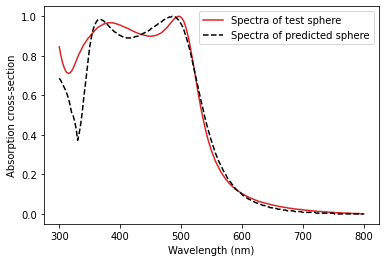

In [17]:
# Setting m1 and m2 to Au@Ag
m1 = 3 # Au
m2 = 1 # Ag

# Importing experimental data
ds = pd.read_csv('Spectra/auag_experimental.csv', sep=',')
w = ds['WL']
q_abs = ds['AuAg_90_140822']

# Normalising spectrum between 0 and 1
q_abs = np.interp(w_g, np.array(w, dtype=np.float64), np.array(q_abs, dtype=np.float64))
q_abs = (q_abs - np.min(q_abs)) / (np.max(q_abs) - np.min(q_abs))

# Model prediction and z-value optimisation
N_ITER = 5 # Number of search iterations
R = 2 # Optimal z-value search radius
mae_opt = 9999 # Optimal MAE (initially set to large value)
z1_opt = 0 # Optimal z1
z2_opt = 0 # Optimal z2

for n_iter in range(N_ITER):
    for i in np.linspace(z1_opt-(R/(2**n_iter)), z1_opt+(R/(2**n_iter)), 5):
        for j in np.linspace(z2_opt-(R/(2**n_iter)), z2_opt+(R/(2**n_iter)), 5):
            m1_pred, m2_pred, t1_pred, t2_pred = model_cvae.predict([np.array([[i, j]]), np.array([q_abs])], verbose=0)

            m1_pred = np.argmax(m1_pred)
            m2_pred = np.argmax(m2_pred)
            t1_pred = t1_pred[0][0][0]*100
            t2_pred = t2_pred[0][0][0]*100

            # Thickness values are set to a minimum of 1
            if t1_pred < 1:
                 t1_pred = 1
            if t2_pred < 1:
                 t2_pred = 1

            # Generating spectrum of predicted nanosphere
            gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
            gen.generate()
            gen.normalise()
            q_abs_pred = gen.q_abs/255

            # Calculating MAE between input and predicted spectra
            mae = np.mean(np.abs(q_abs - q_abs_pred))

            # If MAE is lower than previous optimal MAE, then optimal z1 and z2 values are altered
            if mae < mae_opt:
                mae_opt = mae
                z1_opt = i
                z2_opt = j

# Model prediction using optimal z-values
m1_pred, m2_pred, t1_pred, t2_pred = model_cvae.predict([np.array([[z1_opt, z2_opt]]), np.array([q_abs])], verbose=0)

m1_pred = np.argmax(m1_pred)
m2_pred = np.argmax(m2_pred)
t1_pred = t1_pred[0][0][0]*100
t2_pred = t2_pred[0][0][0]*100

# Thickness values are set to a minimum of 1
if t1_pred < 1:
    t1_pred = 1
if t2_pred < 1:
    t2_pred = 1

# Generating spectrum of predicted nanosphere
gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
gen.generate()
gen.normalise()
q_abs_pred = gen.q_abs/255

# Comparison between test and predicted nanospheres
data = [[mats[m1], mats[m2], '?', '?'],
      [mats[m1_pred], mats[m2_pred], t1_pred, t2_pred], 
      [m1==m1_pred, m2==m2_pred, '?', '?']]
pred_df = pd.DataFrame(data, columns=('m1', 'm2', 't1', 't2'), index=('Test', 'Predicted', 'Error'))

print(pred_df)

# Comparison between test and predicted spectra
fig = plt.figure()
plt.plot(w_g, q_abs, color='tab:red')
plt.plot(w_g, q_abs_pred, color='black', linestyle='--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption cross-section')
plt.legend(('Spectra of test sphere', 'Spectra of predicted sphere'))
plt.show()

## Model Testing

In [18]:
N = 5 # Number of samples to test on (NOTE: cVAE is much slower than Tandem due to latent vector optimisation process)

m1_acc = 0
m2_acc = 0
t1_err = 0
t2_err = 0

for t in range(N):
    print(f'Now {t+1}')
    # Randomly sampling m1 and m2
    m1 = np.random.randint(1, 11)
    m2 = np.random.randint(1, 11)
    while m2 == m1:
        m2 = np.random.randint(1, 11) # Ensuring m1 and m2 are distinct

    # Randomly sampling t1 and t2 while also ensuring t1, t2 >= 1 and t1 + t2 <= 100
    min_thick = 1
    max_thick = 100
    t1 = np.random.uniform(min_thick, max_thick-min_thick)
    max_thick -= t1
    t2 = np.random.uniform(min_thick, max_thick)

    # Generating spectrum of test input sample
    gen = DataGen((m1, m2), (t1, t2), host='wat')
    gen.generate()
    gen.normalise()
    q_abs = gen.q_abs/255 # Normalising spectrum between 0 and 1

    # Model prediction and z-value optimisation
    N_ITER = 5 # Number of search iterations
    R = 2 # Optimal z-value search radius
    mae_opt = 9999 # Optimal MAE (initially set to large value)
    z1_opt = 0 # Optimal z1
    z2_opt = 0 # Optimal z2

    for n_iter in range(N_ITER):
        for i in np.linspace(z1_opt-(R/(2**n_iter)), z1_opt+(R/(2**n_iter)), 5):
            for j in np.linspace(z2_opt-(R/(2**n_iter)), z2_opt+(R/(2**n_iter)), 5):
                m1_pred, m2_pred, t1_pred, t2_pred = model_cvae.predict([np.array([[i, j]]), np.array([q_abs])], verbose=0)

                m1_pred = np.argmax(m1_pred)
                m2_pred = np.argmax(m2_pred)
                t1_pred = t1_pred[0][0][0]*100
                t2_pred = t2_pred[0][0][0]*100

                # Thickness values are set to a minimum of 1
                if t1_pred < 1:
                    t1_pred = 1
                if t2_pred < 1:
                    t2_pred = 1

                # Generating spectrum of predicted nanosphere
                gen = DataGen((m1_pred, m2_pred), (t1_pred, t2_pred), 'wat')
                gen.generate()
                gen.normalise()
                q_abs_pred = gen.q_abs/255

                # Calculating MAE between input and predicted spectra
                mae = np.mean(np.abs(q_abs - q_abs_pred))

                # If MAE is lower than previous optimal MAE, then optimal z1 and z2 values are altered
                if mae < mae_opt:
                    mae_opt = mae
                    z1_opt = i
                    z2_opt = j

    # Model prediction using optimal z-values
    m1_pred, m2_pred, t1_pred, t2_pred = model_cvae.predict([np.array([[z1_opt, z2_opt]]), np.array([q_abs])], verbose=0)

    m1_pred = np.argmax(m1_pred)
    m2_pred = np.argmax(m2_pred)
    t1_pred = t1_pred[0][0][0]*100
    t2_pred = t2_pred[0][0][0]*100

    # Thickness values are set to a minimum of 1
    if t1_pred < 1:
        t1_pred = 1
    if t2_pred < 1:
        t2_pred = 1

    if m1_pred == m1:
        m1_acc += 1

    if m2_pred == m2:
        m2_acc += 1

    t1_err += np.abs(t1_pred - t1)
    t2_err += np.abs(t2_pred - t2)

print(f'm1 Accuracy: {m1_acc/N*100}\nm2 Accuracy: {m2_acc/N*100}\nt1 MAE: {t1_err/N}\nt2 MAE: {t2_err/N}')

Now 1
Now 2
Now 3
Now 4
Now 5
m1 Accuracy: 80.0
m2 Accuracy: 80.0
t1 MAE: 1.679609922776271
t2 MAE: 1.646713021294964
